In [ ]:
# Install if not installed
# Jupyter notebook not work
!pip install driftlens
!pip install h5py

In [89]:
# Phase Estimate therhold
# In this phase noise is undesirable
from driftlens.driftlens import DriftLens
import h5py
import numpy as np

# DriftLens parameters
batch_n_pc = 150 # Number of principal components to reduce per-batch embeddings
per_label_n_pc = 25 # Number of principal components to reduce per-label embeddings
window_size = 1000 # Window size for drift detection
threshold_number_of_estimation_samples = 10000 # Number of sampled windows to estimate the threshold values

# Initialize DriftLens
dl = DriftLens()

file_path = 'test_embedding_mma.hdf5'
#file_path = 'saved_embeddings/train_embedding.hdf5'
file_r = h5py.File(file_path,'r')

training_label_list= [b'mma']

# Extract train archive
E_train = file_r["E"][:100000]
print("E_train:",E_train[0][0:11])
Y_predicted_train = file_r["Y_predicted_names"][:100000]
# Line for copy_file
if "copy" in file_path:
    Y_predicted_train = Y_predicted_train.tolist()
    Y_predicted_train = [ i.decode('utf-8') for i in Y_predicted_train ]
Y_predicted_train = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in Y_predicted_train])
print("Y_predicted_train:",Y_predicted_train[0])

# Extract test archive
E_test = file_r["E"][:100000]
print("E_test:",E_test[0][0:11])
Y_predicted_test = file_r["Y_predicted_names"][:100000]
# Line for copy_file
if "copy" in file_path:
    Y_predicted_test = Y_predicted_train.tolist()
    Y_predicted_test = [ i.decode('utf-8') for i in Y_predicted_test ]
Y_predicted_test = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in Y_predicted_test])
print("Y_predicted_test:",Y_predicted_test[0])

# Extract test archive
E_windows = file_r["E"][58000:]
print("E_windows:",E_windows[0][0:11])
Y_predicted_windows = file_r["Y_predicted_names"][58000:]
X_windows = file_r["X"][58000:]
# Line for copy_file
if "copy" in file_path:
    Y_predicted_windows = Y_predicted_windows.tolist()
    Y_predicted_windows = [ i.decode('utf-8') for i in Y_predicted_windows ]
Y_predicted_windows = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in Y_predicted_windows])
print("Y_predicted_windows:",Y_predicted_windows[0])

print("Init estmimate baseline")
# Estimate the baseline (offline phase)
baseline = dl.estimate_baseline(E=E_train,
                                Y=Y_predicted_train.reshape(1, -1)[0],
                                label_list=training_label_list,
                                batch_n_pc=batch_n_pc,
                                per_label_n_pc=per_label_n_pc)
print("End estmimate baseline")

print("Init threshold")
# Estimate the threshold values with DriftLens (offline phase)
per_batch_distances_sorted, per_label_distances_sorted = dl.random_sampling_threshold_estimation(
                                                            label_list=training_label_list,
                                                            E=E_test,
                                                            Y=Y_predicted_test.reshape(1, -1)[0],
                                                            batch_n_pc=batch_n_pc,
                                                            per_label_n_pc=per_label_n_pc,
                                                            window_size=window_size,
                                                            n_samples=threshold_number_of_estimation_samples,#flag_shuffle=True,
                                                            flag_replacement=False,
                                                            flag_shuffle=False)
print("End threshold")

#print(per_batch_distances_sorted)
#print(per_label_distances_sorted)

#print("Init window")
# Compute the window distribution distances (Frechet Inception Distance) with DriftLens
#dl_distance = dl.compute_window_distribution_distances(E_windows[0], Y_predicted_windows[0])
#print("End window")

E_train: [-0.00165734  0.01341296  0.03427621 -0.03087783  0.04383433 -0.00501704
  0.00276992 -0.0058365   0.01493941 -0.03407554  0.02042883]
Y_predicted_train: [b'mma']
E_test: [-0.00165734  0.01341296  0.03427621 -0.03087783  0.04383433 -0.00501704
  0.00276992 -0.0058365   0.01493941 -0.03407554  0.02042883]
Y_predicted_test: [b'mma']
E_windows: [ 0.08783275  0.01480972 -0.01173681 -0.0195274   0.00120092  0.01729915
 -0.0094363   0.02074364  0.00490986 -0.03277906 -0.01475442]
Y_predicted_windows: [b'mma']
Init estmimate baseline
Y: [b'mma' b'mma' b'mma' ... b'mma' b'mma' b'mma']
label: b'mma'
yes_yes_yes_
End estmimate baseline
Init threshold
Estimating threshold using frechet_drift_distance metric
Threshold Estimation


100%|██████████| 10000/10000 [1:04:10<00:00,  2.60it/s]

End threshold


In [ ]:
def plot_concept(pb_distance):

    import matplotlib.pyplot as plt
    import pandas as pd

    pb_distance = np.array(pb_distance)
    #pb_distance_x = np.array(range(0,len(pb_distance),0.5))
    pb_distance_x = np.arange(0.0, len(pb_distance), 1)
    print(pb_distance.shape)
    #print(len(pb_distance_x))

    fig, ax = plt.subplots()
    ax.plot(pb_distance_x,pb_distance,'o-',color='k')

    ax.grid(True, linestyle='-.')
    ax.tick_params(labelcolor='k', labelsize='medium', width=3)
    threshold = np.real(per_batch_distances_sorted[0])
    #threshold = 2.4
    print("threshold:",np.real(per_batch_distances_sorted[0]))
    ax.axhline(threshold, color='red',linestyle='--')

    # Fill in red if bellow threshold and green if upper threshold
    #ax.fill_between(pb_distance_x, y1=pb_distance, where = pb_distance >= threshold, y2=threshold,facecolor='red', alpha=.5)
    #ax.fill_between(pb_distance_x, y1=pb_distance, where = pb_distance <= threshold, y2=threshold, step='pre',interpolate='True', facecolor='green', alpha=.3)
    pb_distance_up = np.copy(pb_distance)
    pb_distance_up[pb_distance_up<threshold] = threshold

    pb_distance_down = np.copy(pb_distance)
    pb_distance_down[pb_distance_down>=threshold] = threshold
    ax.fill_between(pb_distance_x, y1=pb_distance_up, y2=threshold, facecolor='red', alpha=.5)
    ax.fill_between(pb_distance_x, y1=pb_distance_down, y2=threshold, facecolor='green', alpha=.3)

    #ax.fill_betweenx(pb_distance, threshold, -pb_distance_x )

    # Add labels and title
    plt.xlabel('Windows')
    plt.ylabel('Distância FDD')
    plt.title('Detecção de Concept Drift (per Batch)')

    # Save the fig
    plt.savefig("pb_fig.png")

    # Show the plot
    plt.show()

def parse_metrics(pb_distance):
    threshold = np.real(per_batch_distances_sorted[0])
    print("threshold:",threshold)
    pb_distance_up = np.copy(pb_distance)
    up = pb_distance_up[pb_distance_up>=threshold]
    print("number of samples concept detected:",len(up))

    pb_distance_down = np.copy(pb_distance)
    down = pb_distance_down[pb_distance_down<threshold]
    print("number of samples concept undetected:",len(down))

    print("all:",len(pb_distance))

    acc = float(len(up)/len(pb_distance))*100
    print("accuracy:",acc)

def parse_distance(dl_distance_array):
    from driftlens.driftlens import DriftLensVisualizer

    #print(dl.label_list)

    dv = DriftLensVisualizer()

    df = dl_distance_array[0]["per-label"].keys()
    pl_distance, pb_distance = dv._parse_distribution_distances(df,dl_distance_array)

    # Transform numbers imaginary for real
    for i in pl_distance.keys():
        pl_distance[i] = [np.real(p) for p in pl_distance[i]] 
    print(pl_distance)

    # Transform numbers imaginary for real
    pb_distance = [np.real(p) for p in pb_distance] 
    print(pb_distance)
    print(np.array([pb_distance]))

    #dv.plot_per_batch_drift_monitor(dl_distance_array)

    return pb_distance
    

In [ ]:
print(per_batch_distances_sorted)
print(per_label_distances_sorted)

[0.03846197 0.03747745 0.03679747 0.03672524 0.03656756 0.03632911
 0.03601805 0.03583527 0.0357886  0.03511407 0.0349909  0.03477272
 0.03431318 0.03409273 0.03407674 0.03400911 0.03395763 0.03384834
 0.0338011  0.03377016 0.03374028 0.03370246 0.03368188 0.03367492
 0.03362966 0.0335819  0.03357704 0.03355865 0.03353058 0.0334171
 0.03318854 0.03313346 0.03313122 0.03308358 0.03291553 0.03288958
 0.03287582 0.03279692 0.03276013 0.03261633 0.03245779 0.03243837
 0.03238562 0.03236542 0.03232153 0.03231269 0.03218446 0.03218159
 0.03215548 0.03214993 0.03212012 0.03211086 0.03210069 0.0320728
 0.03206832 0.03195047 0.0319429  0.03193295 0.03193185 0.03192279
 0.03191925 0.03190992 0.03190037 0.03175358 0.03173836 0.03171786
 0.03171512 0.03169501 0.03167882 0.03167174 0.03166017 0.03164086
 0.03161309 0.03159781 0.03158803 0.03155581 0.03153495 0.03152149
 0.03151478 0.03148677 0.03147346 0.03147186 0.03145744 0.03145398
 0.0314457  0.03144431 0.03143345 0.03142362 0.03140586 0.031356

[0.05972879-7.60016272e-13j 0.0585186 +0.00000000e+00j
 0.05797975+0.00000000e+00j 0.0577164 +0.00000000e+00j
 0.05761741-6.31290022e-12j 0.05744828-4.66013395e-12j
 0.05717322-5.73092674e-12j 0.05701235-9.09974271e-12j
 0.05680464-2.07225454e-13j 0.05672066-8.06355707e-12j
 0.0566856 -1.43438304e-12j 0.05658201+0.00000000e+00j
 0.0565121 +0.00000000e+00j 0.05642812-5.00078425e-13j
 0.0563607 +0.00000000e+00j 0.0562532 -8.83762600e-12j
 0.05617749-6.90384060e-12j 0.05616921-1.58152424e-13j
 0.05605625-3.29816588e-13j 0.05598404+0.00000000e+00j
 0.05594844+0.00000000e+00j 0.05593726-5.83104493e-12j
 0.05590028+0.00000000e+00j 0.05586951-1.25752065e-11j
 0.05586497-4.12961233e-12j 0.05580545-8.92209179e-12j
 0.05579397-4.20370284e-13j 0.05575836-2.84187578e-13j
 0.05574278+0.00000000e+00j 0.05573275-1.34361192e-13j
 0.05572815-7.55081517e-12j 0.05562867-8.38740653e-12j
 0.05544175+0.00000000e+00j 0.05542574-6.72176844e-12j
 0.05540466-8.86768707e-12j 0.05538366-9.65555926e-12j
 0.0553793

E_windows: [[ 0.05322229  0.03376512 -0.00162437 ... -0.00224834  0.01375236
   0.02609299]
 [ 0.02082641 -0.02686531 -0.00313109 ... -0.01635076  0.06957197
  -0.00697874]
 [-0.01896523 -0.0210041   0.01710327 ... -0.04289974  0.01463755
  -0.0009203 ]
 ...
 [-0.02261054  0.08082376  0.00521233 ... -0.00298975  0.00149427
  -0.07897403]
 [-0.02261054  0.08082376  0.00521233 ... -0.00298975  0.00149427
  -0.07897403]
 [ 0.01133756  0.02751941 -0.0416716  ... -0.00921604 -0.00376075
  -0.02547491]]
Y_predicted_windows: [[b'mma']
 [b'mma']
 [b'mma']
 ...
 [b'mma']
 [b'mma']
 [b'mma']]
E_windows: [[ 0.04332707  0.00421394  0.02138064 ... -0.00632937  0.00990938
  -0.01210959]
 [ 0.00057142  0.00877628  0.04724747 ... -0.00076756  0.027769
   0.0148411 ]
 [ 0.03174809  0.03553003  0.00836335 ... -0.01601639 -0.01595187
   0.00858267]
 ...
 [ 0.00053363  0.03979846  0.0203008  ...  0.00629501  0.02765327
  -0.01334819]
 [-0.00540869  0.02284748  0.0386868  ... -0.00420976  0.02599994
  -0.0

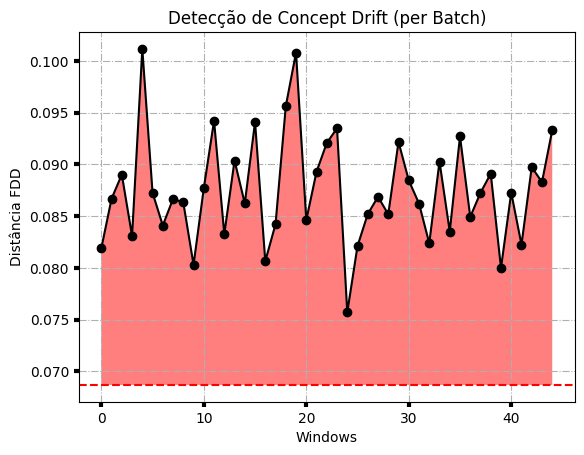

---------- 901 ----------
D(%): 10.0
{"b'mma'": [np.float64(0.020849443885646853), np.float64(0.017476449274842036), np.float64(0.030248558221238883), np.float64(0.0224598453760551), np.float64(0.025114839609801223), np.float64(0.03657322221167759), np.float64(0.0236482527887578), np.float64(0.01815571712183104), np.float64(0.02450353550772509), np.float64(0.02634565678274497), np.float64(0.017943104650781888), np.float64(0.031868440911088494), np.float64(0.03972997950360885), np.float64(0.031133890235151028), np.float64(0.019335640908835675), np.float64(0.04055807191391303), np.float64(0.03917581623294495), np.float64(0.01908878533759903), np.float64(0.019852339246666573), np.float64(0.03946096341476375), np.float64(0.03260263276288613), np.float64(0.020748709507730348), np.float64(0.023219380354924653), np.float64(0.024666036377574724), np.float64(0.024874676184296254), np.float64(0.018458412047363114), np.float64(0.020444913257703777), np.float64(0.020432726492446724), np.float64(0.

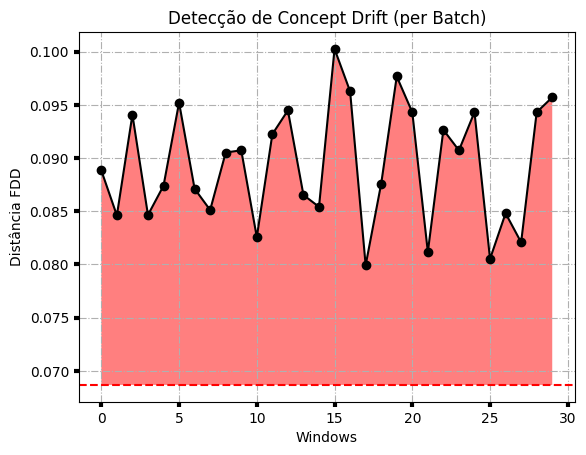

---------- 801 ----------
D(%): 20.0
{"b'mma'": [np.float64(0.021964334639426413), np.float64(0.01914164555499993), np.float64(0.025976804655108498), np.float64(0.02712343022830785), np.float64(0.029181265336624698), np.float64(0.033971105696250434), np.float64(0.02456324113183189), np.float64(0.021060903701300048), np.float64(0.027951370211076437), np.float64(0.028428093974547403), np.float64(0.026114423831586416), np.float64(0.03085650283139478), np.float64(0.03670518258067725), np.float64(0.02534590821931396), np.float64(0.021598467100629966), np.float64(0.043634036712955904), np.float64(0.03672029285642195), np.float64(0.019076198914172733), np.float64(0.022535942263670467), np.float64(0.029587038179491536), np.float64(0.030840500291693086), np.float64(0.03286425738579392), np.float64(0.021940948447933924), np.float64(0.02393418447166539), np.float64(0.02405656353312086), np.float64(0.018678391071189654), np.float64(0.021110873185949626), np.float64(0.026349555959735708), np.float6

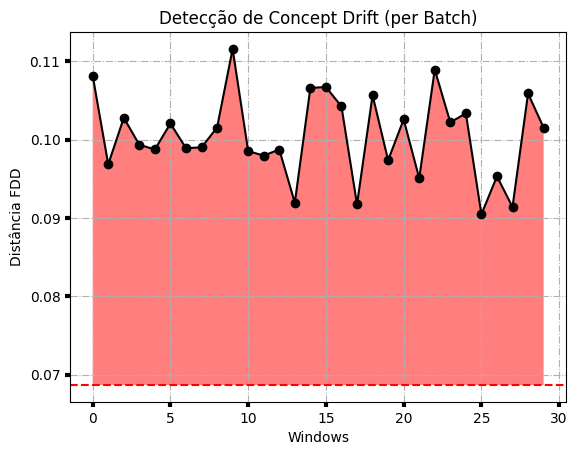

---------- 701 ----------
D(%): 30.0
e
{"b'mma'": [np.float64(0.024145749314893095), np.float64(0.03168756056255296), np.float64(0.028131842746433794), np.float64(0.029124363726599472), np.float64(0.027197692668386453), np.float64(0.025577079688555777), np.float64(0.03653583745099717), np.float64(0.02696207562231907), np.float64(0.029020322578081174), np.float64(0.02127837711694139), np.float64(0.027940461929869237), np.float64(0.03555114828302445), np.float64(0.045180214068082626), np.float64(0.022011779680360916), np.float64(0.03419051763945085), np.float64(0.03390488289232151), np.float64(0.03144326596781259), np.float64(0.02672890219588684), np.float64(0.02327360176163195), np.float64(0.02604643580481913), np.float64(0.029990935902837964), np.float64(0.02619620101465426), np.float64(0.027049803847424645), np.float64(0.025229149213671927), np.float64(0.020611295285144566), np.float64(0.03883225930493775), np.float64(0.03729765993576996), np.float64(0.02885947122375792), np.float64(0

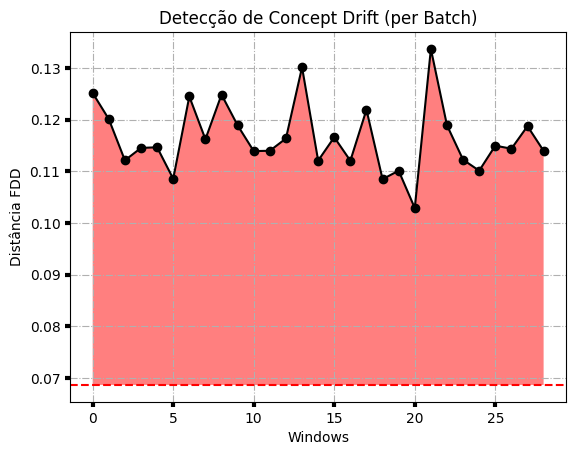

---------- 601 ----------
D(%): 40.0
{"b'mma'": [np.float64(0.027217764412983774), np.float64(0.029269648388851065), np.float64(0.025551666892509952), np.float64(0.025569070598524497), np.float64(0.03841680576565673), np.float64(0.033025981923819066), np.float64(0.03135126744151108), np.float64(0.03867807005848206), np.float64(0.038387368166952235), np.float64(0.026514717372765964), np.float64(0.02247643475096068), np.float64(0.02740315802523864), np.float64(0.03035179815529201), np.float64(0.03930589619786236), np.float64(0.032535453661204666), np.float64(0.03371821506328954), np.float64(0.029912813914934132), np.float64(0.03220632705177909), np.float64(0.025795750909929898), np.float64(0.02771130487828695), np.float64(0.036508635834821376), np.float64(0.030843565889468134), np.float64(0.04232677900450175), np.float64(0.034160259285438956), np.float64(0.03062788302866157), np.float64(0.029710613065905684), np.float64(0.031558989235333915), np.float64(0.02900616650741481), np.float64(0

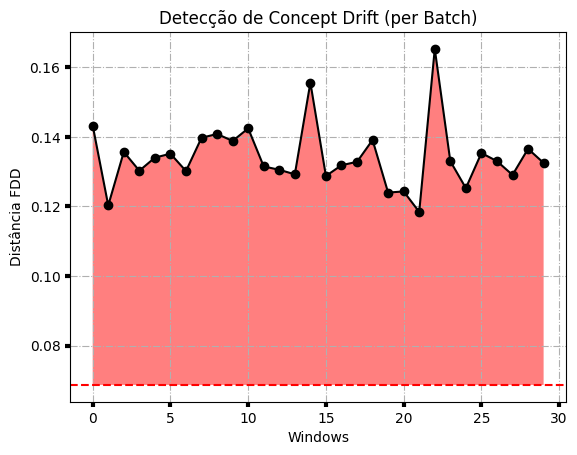

---------- 501 ----------
D(%): 50.0
e
e
e
e
e
{"b'mma'": [np.float64(0.026550601509390096), np.float64(0.04956892366863463), np.float64(0.030843400003698472), np.float64(0.022951290095837056), np.float64(0.044802381340336025), np.float64(0.05039412783687361), np.float64(0.03718577394536175), np.float64(0.024693190007851716), np.float64(0.04390063690220582), np.float64(0.04270520090424827), np.float64(0.03390723793370238), np.float64(0.03339149419587947), np.float64(0.033122018160733145), np.float64(0.04886411199937277), np.float64(0.046027005772780565), np.float64(0.042086855263617134), np.float64(0.024942304679360216), np.float64(0.04891515545028273), np.float64(0.0350983904033901), np.float64(0.03588392627723146), np.float64(0.04391636442728626), np.float64(0.04209730301280696), np.float64(0.03593677759183679), np.float64(0.03869189449409344), np.float64(0.025969789466334797)]}
[np.float64(0.15831429865053795), np.float64(0.13709167120609694), np.float64(0.1569019633009952), np.floa

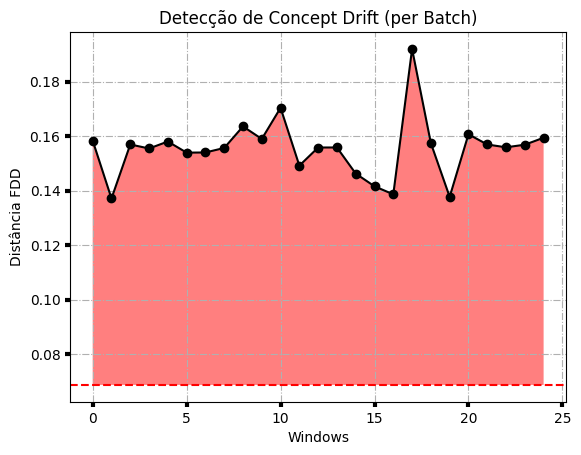

In [86]:
# Load principal class with theme 'mma'
file_path = 'test_embedding_mma.hdf5'
file_r = h5py.File(file_path,'r')

E_windows = file_r["E"][100000:200000]
print("E_windows:",E_windows)
Y_predicted_windows = file_r["Y_predicted_names"][100000:200000]
X_windows = file_r["X"][100000:200000]
# Line for copy_file
if "copy" in file_path:
    Y_predicted_windows = Y_predicted_windows.tolist()
    Y_predicted_windows = [ i.decode('utf-8') for i in Y_predicted_windows ]
Y_predicted_windows = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in Y_predicted_windows])
print("Y_predicted_windows:",Y_predicted_windows)

file_r.close()

# Load noise class with theme 'vacinal'
file_path = 'test_embedding_vacinal.hdf5'
file_r = h5py.File(file_path,'r')

E_windows_d = file_r["E"][:-1]
print("E_windows:",E_windows_d)
Y_predicted_windows_d = file_r["Y_predicted_names"][:-1]
X_windows_d = file_r["X"][:-1]
# Line for copy_file
if "copy" in file_path:
    Y_predicted_windows_d = Y_predicted_windows_d.tolist()
    Y_predicted_windows_d = [ i.decode('utf-8') for i in Y_predicted_windows_d ]
Y_predicted_windows_d = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in Y_predicted_windows_d])
print("Y_predicted_windows:",Y_predicted_windows_d)

file_r.close()

graduation = [1001,901,801,701,601,501]
for g_noise in graduation:
    # Compute distances concept drift
    print("-"*10,g_noise,"-"*10)
    perc_D = ( (1001-g_noise)/1000 ) * 100
    print("D(%):",perc_D)
    dl_distance_array = []
    if 1001-g_noise == 0:
        for idx in range(0,int(len(E_windows)/2),1000):
            try:         
                Y = Y_predicted_windows[idx+1:1001+idx]
                E = E_windows[idx+1:1001+idx]
                #print("len E:",len(E))
                #print(Y)
                #print(E)
                if len(E)==1000:
                    dl_distance = dl.compute_window_distribution_distances(E, Y.reshape(1, -1)[0])
                    dl_distance_array.append(dl_distance)
                #else:
                #    print('not size min')
            except:
                print("e")
    else:
        for idx in range(0,int(len(E_windows)/2),1000):
            #print("Session:",int(idx/100))
            try:
                Y = np.vstack((Y_predicted_windows[idx+1:g_noise+idx],Y_predicted_windows_d[idx+g_noise:1001+idx]))
                E = E_windows[idx+1:1001+idx]
                E = np.vstack((E_windows[idx+1:g_noise+idx],E_windows_d[idx+g_noise:1001+idx]))
                #print("len E:",len(E))
                #print(Y)
                #print(E)
                if len(E)==1000:
                    dl_distance = dl.compute_window_distribution_distances(E, Y.reshape(1, -1)[0])
                    dl_distance_array.append(dl_distance)
                #else:
                #    print('not size min')
            except:
                print("e")
    pb_dist = parse_distance(dl_distance_array)
    parse_metrics(pb_dist)
    plot_concept(pb_dist)


E_windows: [[-0.00165734  0.01341296  0.03427621 ...  0.03421231  0.0014446
  -0.0502655 ]
 [ 0.00909136  0.00581945 -0.00611988 ... -0.01501157  0.06077188
  -0.02440913]
 [ 0.00909136  0.00581945 -0.00611988 ... -0.01501157  0.06077188
  -0.02440913]
 ...
 [-0.00848876 -0.00210489  0.03473288 ... -0.02400371  0.00734686
   0.0214709 ]
 [-0.00848876 -0.00210489  0.03473288 ... -0.02400371  0.00734686
   0.0214709 ]
 [ 0.00118828  0.05170171  0.0223583  ... -0.02128319 -0.00618567
   0.02295608]]
Y_predicted_windows: [[b'mma']
 [b'mma']
 [b'mma']
 ...
 [b'mma']
 [b'mma']
 [b'mma']]
E_windows: [[ 0.04332707  0.00421394  0.02138064 ... -0.00632937  0.00990938
  -0.01210959]
 [ 0.00057142  0.00877628  0.04724747 ... -0.00076756  0.027769
   0.0148411 ]
 [ 0.03174809  0.03553003  0.00836335 ... -0.01601639 -0.01595187
   0.00858267]
 ...
 [ 0.00053363  0.03979846  0.0203008  ...  0.00629501  0.02765327
  -0.01334819]
 [-0.00540869  0.02284748  0.0386868  ... -0.00420976  0.02599994
  -0.02

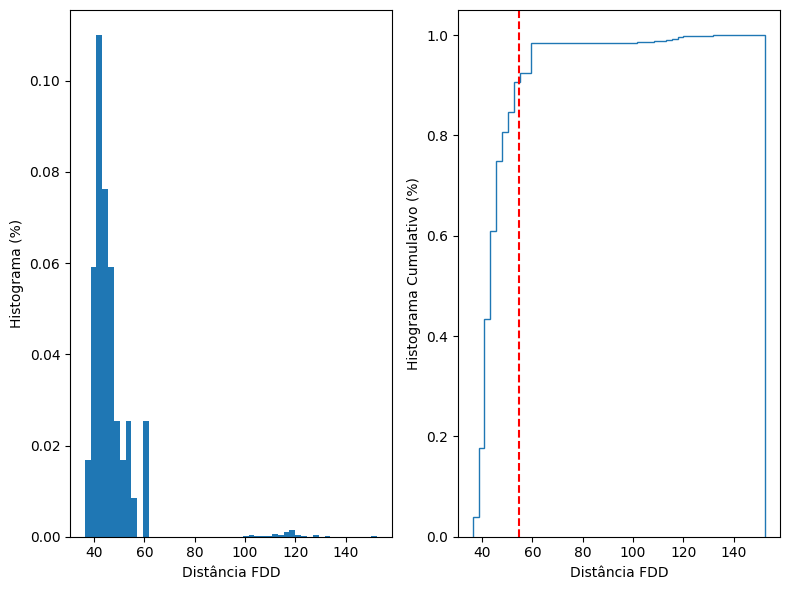

In [73]:
# Generate histogram
# Load principal class with theme 'mma'
file_path = 'test_embedding_mma.hdf5'
file_r = h5py.File(file_path,'r')

E_windows = file_r["E"][:100000]
print("E_windows:",E_windows)
Y_predicted_windows = file_r["Y_predicted_names"][:100000]
X_windows = file_r["X"][:100000]
# Line for copy_file
if "copy" in file_path:
    Y_predicted_windows = Y_predicted_windows.tolist()
    Y_predicted_windows = [ i.decode('utf-8') for i in Y_predicted_windows ]
Y_predicted_windows = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in Y_predicted_windows])
print("Y_predicted_windows:",Y_predicted_windows)

file_r.close()

# Load noise class with theme 'vacinal'
file_path = 'test_embedding_vacinal.hdf5'
file_r = h5py.File(file_path,'r')

E_windows_d = file_r["E"][:-1]
print("E_windows:",E_windows_d)
Y_predicted_windows_d = file_r["Y_predicted_names"][:-1]
X_windows_d = file_r["X"][:-1]
# Line for copy_file
if "copy" in file_path:
    Y_predicted_windows_d = Y_predicted_windows_d.tolist()
    Y_predicted_windows_d = [ i.decode('utf-8') for i in Y_predicted_windows_d ]
Y_predicted_windows_d = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in Y_predicted_windows_d])
print("Y_predicted_windows:",Y_predicted_windows_d)

file_r.close()


for idx in range(0,int(len(E_windows)/2),1000):
    try:         
        Y = Y_predicted_windows[idx+1:1001+idx]
        E = E_windows[idx+1:1001+idx]
        #print("len E:",len(E))
        #print(Y)
        #print(E)
        if len(E)==1000:
            dl_distance = dl.compute_window_distribution_distances(E, Y.reshape(1, -1)[0])
            dl_distance_array.append(dl_distance)
        #else:
        #    print('not size min')
    except:
        print("e")

pb_dist = parse_distance(dl_distance_array)

import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MultipleLocator

fig, axs = plt.subplots(1,2,figsize=(8, 6),tight_layout=True)

# without a thousand mult not work density True in hist
pb_dist =  np.array(pb_dist)*1000

n_bins=50
# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(pb_dist, bins=n_bins, density=True)

axs[0].set_xlabel('Distância FDD')
axs[0].set_ylabel('Histograma (%)')

n, bins, patches = axs[1].hist(pb_dist, n_bins, density=True, histtype="step",
                               cumulative=True, label="Cumulative histogram")

axs[1].set_xlabel('Distância FDD')
axs[1].set_ylabel('Histograma Cumulativo (%)')


threshold_percent_90 = np.percentile(pb_dist, 90)
axs[1].axvline(threshold_percent_90, color='red',linestyle='--')

#axs.xaxis.set_major_locator(MultipleLocator(0.01))
#axs.xaxis.set_minor_locator(MultipleLocator(0.005))
#axs.yaxis.set_major_formatter(PercentFormatter(xmax=1))
'''
# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
'''
plt.show()



In [7]:
print(len(E_windows_d))

30754


In [103]:
!pip install matplotlib-inline

In [ ]:
import numpy as np

print("Init window")
print(len(E_windows))
print(E_windows[0:10])
print(Y_predicted_windows[0:10])
# Compute the window distribution distances (Frechet Inception Distance) with DriftLens
#dl_distance = dl.compute_window_distribution_distances(E_windows[1:101], Y_predicted_windows[1:101])

#print(dl_distance)


print(len(E_windows[1:101]))
a = np.array(['World']*40+['Sports']*20+['Business']*40)
#a = np.array(['World']*98+['Sports']+['Business'])

#a = np.random.shuffle(a)
a = a.reshape(1,-1)[0]
print(a)
#dl_distance = dl.compute_window_distribution_distances(E_windows[1:1000], a)
#print(dl_distance)

a = np.array(['World']*4+['Sports']*3+['Business']*3)
#a = np.array(['World']*98+['Sports']+['Business'])

#a = np.random.shuffle(a)
a = a.reshape(1,-1)[0]
#dl_distance = dl.compute_window_distribution_distances(E_windows[1:11], a)
#print(dl_distance)
print("End window")

print("-"*10)
dl_distance_array = []
for i in range(0,len(E_windows),1000):
    print("Session:",int(i/1000))
    Y = Y_predicted_windows[i+1:1001+i]
    E = E_windows[i+1:1001+i]
    #print(Y)
    #print(E)
    dl_distance = dl.compute_window_distribution_distances(E, Y.reshape(1, -1)[0])
    dl_distance_array.append(dl_distance)

#dl.plot_per_batch_drift_monitor(dl_distance_array)


Init window
10000
[[-0.00412767  0.03141647 -0.00601767 ...  0.01228912 -0.01276926
  -0.01874563]
 [-0.02028551  0.01113448 -0.02845977 ... -0.02082578  0.02442501
   0.01520941]
 [ 0.0333406  -0.0253269   0.05797544 ... -0.03995902  0.02364475
  -0.01181266]
 ...
 [ 0.00355933  0.02722822  0.0062935  ...  0.00224072 -0.01568711
   0.00201458]
 [ 0.00741488  0.02108383  0.00666934 ... -0.01230121  0.00586514
   0.01674504]
 [ 0.01864885  0.02289237 -0.01481009 ... -0.00491268 -0.00468906
   0.01894324]]
[[b'mma']
 [b'mma']
 [b'mma']
 [b'mma']
 [b'mma']
 [b'mma']
 [b'mma']
 [b'mma']
 [b'mma']
 [b'mma']]
100
['World' 'World' 'World' 'World' 'World' 'World' 'World' 'World' 'World'
 'World' 'World' 'World' 'World' 'World' 'World' 'World' 'World' 'World'
 'World' 'World' 'World' 'World' 'World' 'World' 'World' 'World' 'World'
 'World' 'World' 'World' 'World' 'World' 'World' 'World' 'World' 'World'
 'World' 'World' 'World' 'World' 'Sports' 'Sports' 'Sports' 'Sports'
 'Sports' 'Sports' 'Spor

In [104]:
for i in range(0,len(pb_distance)):
    print("Window:",i)
    if pb_distance[i] >= threshold:
        print("Drift detected in window:",i)
        Y = Y_predicted_windows[i*1000+1:1001+i*1000]
        E = E_windows[i*1000+1:1001+i*1000]
        X = X_windows[i*1000+1:1001+i*1000]
        print(Y[0])
        print(E[0][0:11])
        print(X[0])

Window: 0
Window: 1
Window: 2
Window: 3
Window: 4
Window: 5
Window: 6
Window: 7
Window: 8
Window: 9
Window: 10
Window: 11
Window: 12
Drift detected in window: 12


IndexError: index 0 is out of bounds for axis 0 with size 0

(32,)
32
threshold: 2.5864924707087136


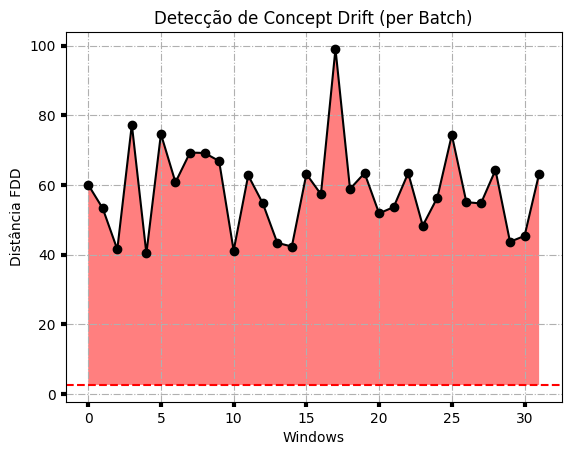

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pb_distance = np.array(pl_distance['Sports'])
#pb_distance_x = np.array(range(0,len(pb_distance),0.5))
pb_distance_x = np.arange(0.0, len(pb_distance), 1)
print(pb_distance.shape)
print(len(pb_distance_x))
fig, ax = plt.subplots()
ax.plot(pb_distance_x,pb_distance,'o-',color='k')

ax.grid(True, linestyle='-.')
ax.tick_params(labelcolor='k', labelsize='medium', width=3)
threshold = np.real(per_batch_distances_sorted[0])
#threshold = 2.4
print("threshold:",np.real(per_batch_distances_sorted[0]))
ax.axhline(threshold, color='red',linestyle='--')

# Fill in red if bellow threshold and green if upper threshold
#ax.fill_between(pb_distance_x, y1=pb_distance, where = pb_distance >= threshold, y2=threshold,facecolor='red', alpha=.5)
#ax.fill_between(pb_distance_x, y1=pb_distance, where = pb_distance <= threshold, y2=threshold, step='pre',interpolate='True', facecolor='green', alpha=.3)
pb_distance_up = np.copy(pb_distance)
pb_distance_up[pb_distance_up<threshold] = threshold

pb_distance_down = np.copy(pb_distance)
pb_distance_down[pb_distance_down>=threshold] = threshold
ax.fill_between(pb_distance_x, y1=pb_distance_up, y2=threshold, facecolor='red', alpha=.5)
ax.fill_between(pb_distance_x, y1=pb_distance_down, y2=threshold, facecolor='green', alpha=.3)

#ax.fill_betweenx(pb_distance, threshold, -pb_distance_x )

# Add labels and title
plt.xlabel('Windows')
plt.ylabel('Distância FDD')
plt.title('Detecção de Concept Drift (per Batch)')

# Show the plot
plt.show()